# ASX 200 Performance and Sydney Weather

An entirely experimental analysis as to whether or not rain in sydney at all correlates with stock market performance on the asx 200. Using YFinance and publicly avaliable Beauro of meterology data the analysis runs from the beginning of this year 1st january 2020 until the 11th of June 2020

Expecting to see no correlation but a fun experiment in data collection and plotting

First we going to collect the ASX200 data from yahoo finance, using the yfinance library

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
#Generate a yfinance ticker object using the Ticker module, in this case the asx200 is represented by ^AXJO
xjo = yf.Ticker('^AXJO')
#Place the data into a Pandas dataframe
stock = pd.DataFrame(xjo.history(period='6mo'))

Remove columns we dont need, working of open prices for today, Then calculate a new column which documents the percentage change each day. Also retrieve a binary change column simply to represent 0 for a loss, and 1 for a gain in the market

In [2]:
stock.drop(['High','Low','Close','Volume','Dividends','Stock Splits'],axis=1,inplace=True)
stock['Change'] = stock.pct_change()

In [3]:
def changebin(x):
    return 0 if x <= 0 else 1

In [4]:
stock['binChange'] = stock['Change'].apply(changebin)
stock = stock.iloc[13:-1]
stock.head()

,Open,Change,binChange
Date,,,
2020-01-02,6684.1,-0.017752,0
2020-01-03,6690.6,0.000972,1
2020-01-06,6733.1,0.006352,1
2020-01-07,6735.7,0.000386,1
2020-01-08,6826.4,0.013466,1


We have our stock data collected, now we need to get our weather data. Taken from this page from the bearu of meterology: http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_nccObsCode=136&p_display_type=dailyDataFile&p_startYear=&p_c=&p_stn_num=066062

Some work was done in excel to get a CSV file with dates and rainfall values, matching up for only the days the ASX market is traded, now we have a table wih rain and stock data aligned

In [16]:
rain = pd.read_csv('Weatherdata/rainfalltest.csv', parse_dates=['Date']).dropna()
rain.set_index('Date')
stock['rain'] = rain['Rain'].values
stock['binrain'] = stock['rain'].apply(changebin)
stock.head()

,Open,Change,binChange,rain,binrain
Date,,,,,
2020-01-02,6684.1,-0.017752,0,0.0,0
2020-01-03,6690.6,0.000972,1,0.0,0
2020-01-06,6733.1,0.006352,1,0.0,0
2020-01-07,6735.7,0.000386,1,2.6,1
2020-01-08,6826.4,0.013466,1,2.8,1


Export data into a CSV file, so we can have a single data file to work with

In [17]:
stock.to_csv('Stock_Rain.csv')

## Plotting our data to observe any trends

Use matplotlib to see if there are trends between these two variables, looking for any consistent movement

Read in the data set up on the 11/6/20, this will allow us to revise process in future

In [18]:
df = pd.read_csv('Weatherdata/Stock_Rain_11_6.csv', parse_dates=['Date'])

In [22]:
plt.style.use('seaborn-whitegrid')
import seaborn as sb

Lets have a look at the data we are working with, we have 4 columns of interset
- Change, change in the stock index level each day
- binChange, 0 if the index moves negative, 1 if positive
- rain, level of rainfall measured at observatory hill in sydney city each day
- binrain, a binary value of 0 if no rain and 1 if rain

In [31]:
df.drop('Open', axis=1,inplace=True)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Date,Change,binChange,rain,binrain
0,2020-01-02,-0.017752,0,0.0,0
1,2020-01-03,0.000972,1,0.0,0
2,2020-01-06,0.006352,1,0.0,0
3,2020-01-07,0.000386,1,2.6,1
4,2020-01-08,0.013466,1,2.8,1


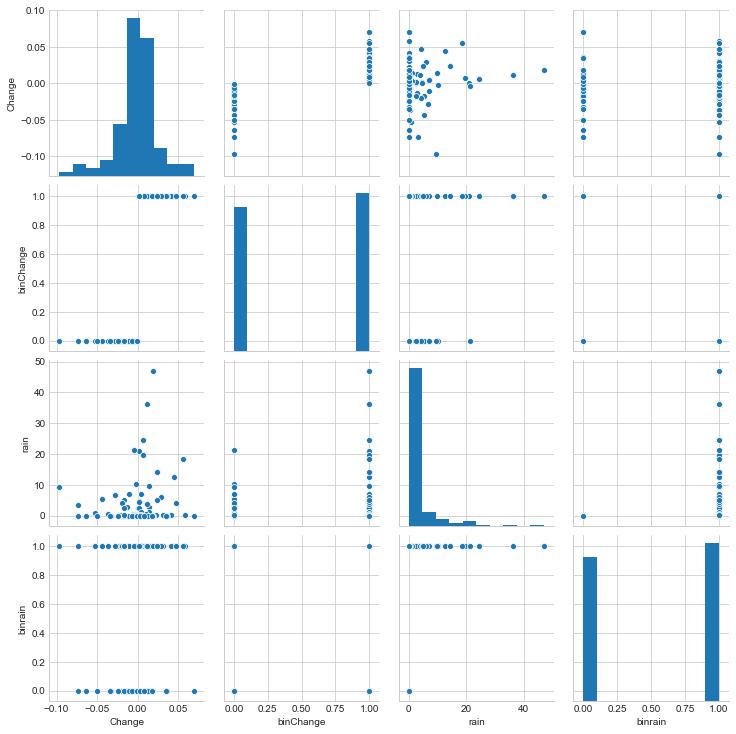

In [32]:
sb.pairplot(df)

The rain variable has some seris outliers which are skewing our graphs fairly heavily, lets apply a filter to remove the outliers

In [28]:
from scipy import stats
import numpy as np
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df = df[(np.abs(stats.zscore(df.rain)) < 3)]

Now lets run the pairplot function once more with a regression line for each plot

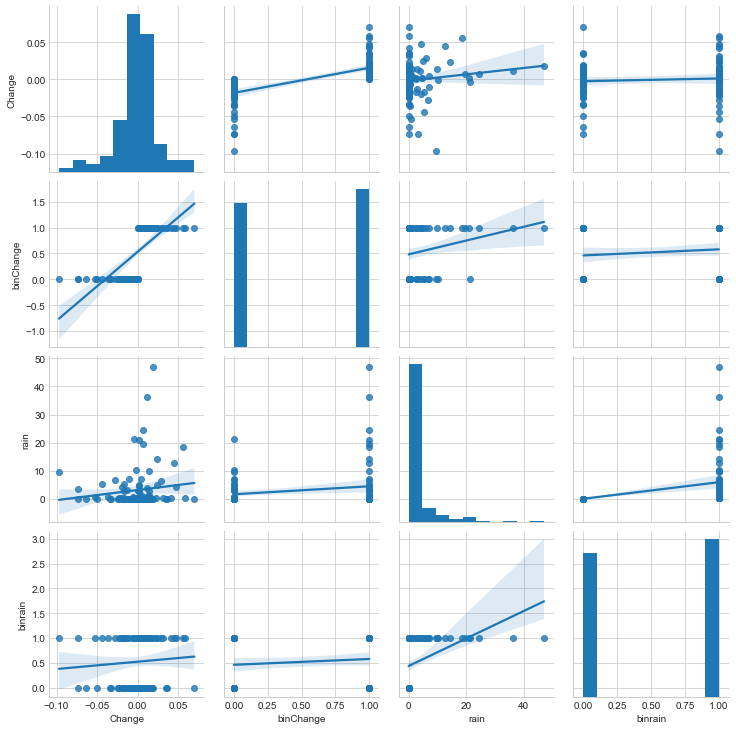

In [34]:
sb.pairplot(df, kind='reg')

Results are as expected less than optimal, there doesnt seem to be any clear support for the theory that rain leads to losses on the ASX, infact it seems to show almost the opposite with slight positive relationships between rain and gains, this is to be taken with a grain of salt, as the stock market goes up more often than down in this time period see above, and also it rains more often, lets do some more statistical tests

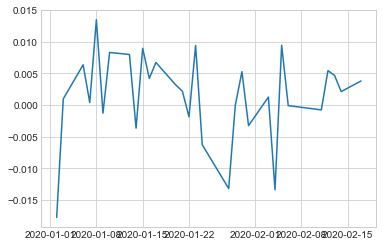

In [43]:
plt.plot('Date','Change', data=df.iloc[0:30], label='stock change')
plt.show()

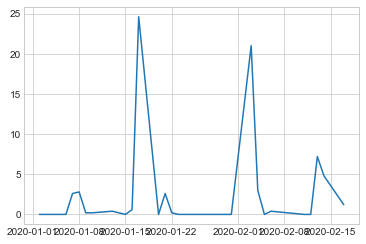

In [42]:
plt.plot('Date','rain', data=df.iloc[0:30], label='rainfall')
plt.show()

Lets combine these onto a singular axis, to see the results lined up, it is looking promising for this theory

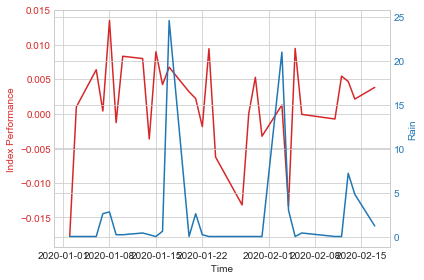

In [46]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(' Time ')
ax1.set_ylabel('Index Performance', color=color)
ax1.plot('Date','Change', data=df.iloc[0:30], label='stock change',color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Rain', color=color)
ax2.plot('Date','rain', data=df.iloc[0:30], label='rainfall',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

plt.show()

Not a clear relationship in this figure at all, lets try with the binary figure and also some different data ranges

<Figure size 432x1440 with 0 Axes>

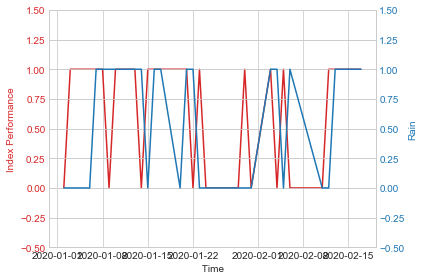

In [50]:
#this time with binary values, instead of the regular vals.
plt.figure(figsize=(6,20))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(' Time ')
ax1.set_ylabel('Index Performance', color=color)
ax1.plot('Date','binChange', data=df.iloc[0:30], label='stock change',color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ybound(lower=-0.5,upper=1.5)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Rain', color=color)
ax2.plot('Date','binrain', data=df.iloc[0:30], label='rainfall',color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ybound(lower=-0.5,upper=1.5)
fig.tight_layout()

plt.show()

Lets try a different date range, in these first two instances we have taken the first 30 days, now lets take the next 30

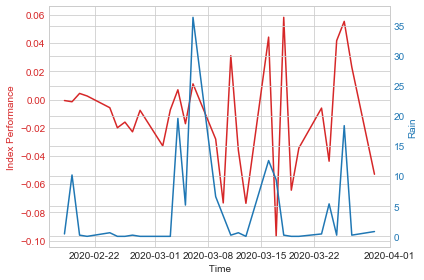

In [51]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(' Time ')
ax1.set_ylabel('Index Performance', color=color)
ax1.plot('Date','Change', data=df.iloc[30:60], label='stock change',color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Rain', color=color)
ax2.plot('Date','rain', data=df.iloc[30:60], label='rainfall',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

plt.show()

<Figure size 432x1440 with 0 Axes>

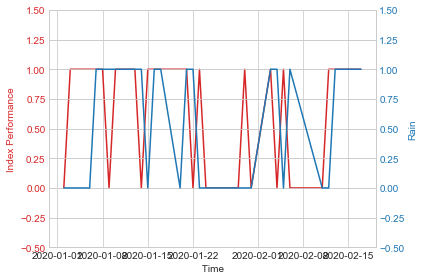

In [52]:
#this time with binary values, instead of the regular vals.
plt.figure(figsize=(6,20))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(' Time ')
ax1.set_ylabel('Index Performance', color=color)
ax1.plot('Date','binChange', data=df.iloc[0:30], label='stock change',color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ybound(lower=-0.5,upper=1.5)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Rain', color=color)
ax2.plot('Date','binrain', data=df.iloc[0:30], label='rainfall',color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ybound(lower=-0.5,upper=1.5)
fig.tight_layout()

plt.show()

And once more to showcase again another 30 days worth of time

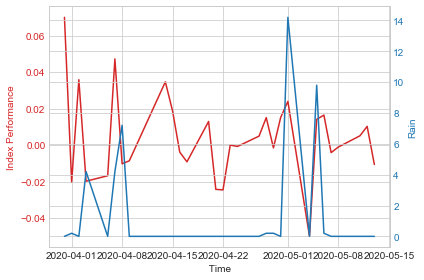

In [53]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(' Time ')
ax1.set_ylabel('Index Performance', color=color)
ax1.plot('Date','Change', data=df.iloc[60:90], label='stock change',color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Rain', color=color)
ax2.plot('Date','rain', data=df.iloc[60:90], label='rainfall',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

plt.show()

<Figure size 432x1440 with 0 Axes>

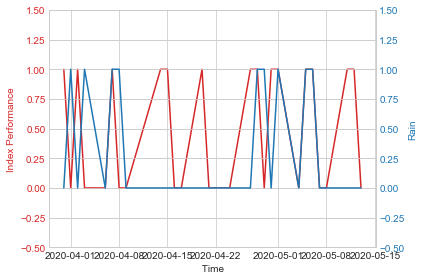

In [54]:
#this time with binary values, instead of the regular vals.
plt.figure(figsize=(6,20))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(' Time ')
ax1.set_ylabel('Index Performance', color=color)
ax1.plot('Date','binChange', data=df.iloc[60:90], label='stock change',color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ybound(lower=-0.5,upper=1.5)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Rain', color=color)
ax2.plot('Date','binrain', data=df.iloc[60:90], label='rainfall',color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ybound(lower=-0.5,upper=1.5)
fig.tight_layout()

plt.show()

So far we have little in the way of a relationship, all of our visuals seem to show no linkage between rain and performance, looking random in almost all cases.

Because im crazy lets create a linear regression model to see what kind of relationship we can find if any between these variables, first we clean up change and rain for outliers, then run the model

Coefficients  [0.00062246]
Mean Squared Error  0.00043961488612091266
Coefficient of determination  0.013409057441511107


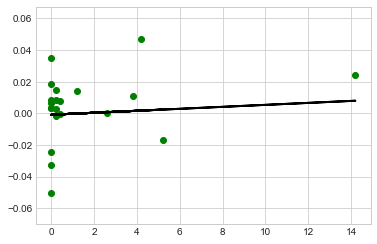

In [64]:
df = df[(np.abs(stats.zscore(df.Change)) < 3)]
df = df[(np.abs(stats.zscore(df.rain)) < 3)]

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()

x = df['rain'].values.reshape(-1,1)

xtrain, xtest, ytrain, ytest = train_test_split(x, df['Change'].values, test_size=0.2)

lr.fit(xtrain, ytrain)

y_pred =  lr.predict(xtest)

#The coefficients
print('Coefficients ', lr.coef_)
#Mean square error
print('Mean Squared Error ', str(mean_squared_error(ytest,y_pred)))
#Coefficient of determination our r^2 value
print('Coefficient of determination ', str(r2_score(ytest,y_pred)))
      
      
#plot the graph
plt.scatter(xtest,ytest, color='green')
plt.plot(xtest,y_pred, color='black', linewidth=2)

#plt.xticks(())
#plt.yticks(())

plt.show()

And there we have it, the final proof needed to throw away this idea, with a r^2 score of 0.0134, it is clear that rain does not explain or have a link to rises or losses on the ASX200,

This excersie was fun however, thanks for coming along for the ride, We had a series play with data injestion and processing as well as some fairly advanced matplotlib, a learning journey nevertheless